In [1]:
import gradio as gr
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict, Annotated, List, Dict, Any
from datetime import datetime
from IPython.display import Image, display
import operator

In [2]:
# ──────────────── STATE DEFINITION ────────────────
class CustomerState(TypedDict):
    user_message: Annotated[str, "readonly"]
    chat_history: Annotated[List[Dict[str, str]], "add"]
    assigned_agents: Annotated[List[str], "set"]
    agent_results: Annotated[Dict[str, str], operator.or_]
    final_response: Annotated[str, "set"]
    logs: Annotated[List[str], operator.add]

In [3]:
# ──────────────── Intake Officer ────────────────
def intake_node(state: CustomerState) -> CustomerState:
    user_msg = state["user_message"].lower()
    # ตอบเองถ้าเป็นคำทักทาย/ขอบคุณ
    if any(word in user_msg for word in ["hello", "hi", "สวัสดี", "ขอบคุณ", "thank"]):
        state["final_response"] = "🙋‍♀️ สวัสดีค่ะ! มีอะไรให้ช่วยไหมคะ?"
        state["logs"].append(f"[{datetime.now().isoformat(timespec='seconds')}] INTAKE: ตอบเอง (direct)")
        return state

    assigned = []
    if "สินค้า" in user_msg or "product" in user_msg:
        assigned.append("product_agent")
    if "บิล" in user_msg or "bill" in user_msg:
        assigned.append("billing_agent")
    if not assigned:
        # ถ้าไม่เข้า keyword ใดๆ ตอบเองเลย
        state["final_response"] = "🤔 ขออภัยค่ะ ฉันไม่เข้าใจคำถามของคุณ กรุณาลองใหม่"
        state["logs"].append(f"[{datetime.now().isoformat(timespec='seconds')}] INTAKE_OFFIER: ตอบเอง (default)")
        return state
    state["assigned_agents"] = assigned
    state["logs"].append(f"[{datetime.now().isoformat(timespec='seconds')}] INTAKE_OFFIER: Assigned {assigned}")
    return state

In [4]:
# ──────────────── PRODUCT AGENT ────────────────
def product_agent(state: CustomerState) -> dict:
    response = "📦 product_agent ข้อมูลสินค้า: iPhone 15 Pro Max, ราคา 45,900 บาท"
    log = f"[{datetime.now().isoformat(timespec='seconds')}] PRODUCT_AGENT: Responded"
    return {"agent_results": {"product_agent": response}, "logs": [log]}

In [5]:
# ──────────────── BILLING AGENT ────────────────
def billing_agent(state: CustomerState) -> dict:
    response = "🧾 billing_agent ข้อมูลบิลล่าสุด: ใบเสร็จส่งไปที่ customer@email.com"
    log = f"[{datetime.now().isoformat(timespec='seconds')}] BILLING_AGENT: Responded"
    return {"agent_results": {"billing_agent": response}, "logs": [log]}

In [6]:
# ──────────────── AGGREGATOR (Reduce Node) ────────────────
def aggregator_node(state: CustomerState) -> dict:
    assigned = set(state.get("assigned_agents", []))
    results = state.get("agent_results", {})
    logs = []
    # รอจนกว่าทุก agent ที่ assigned จะตอบครบ
    if not assigned <= set(results.keys()):
        waiting = list(assigned - set(results.keys()))
        logs.append(f"[{datetime.now().isoformat(timespec='seconds')}] AGGREGATOR: Waiting for {waiting} ...")
        return {"logs": logs}
    # รวมผล
    answer = ""
    for agent in assigned:
        answer += results[agent] + "\n\n"
    logs.append(f"[{datetime.now().isoformat(timespec='seconds')}] AGGREGATOR: Aggregated response")
    return {"final_response": answer, "logs": logs}

In [7]:
# ──────────────── WORKFLOW ────────────────
def intake_router(state):
    # DEBUG: เพิ่ม log เพื่อดูว่า router ถูกเรียกและคืนค่าอะไร
    print(f"🔍 DEBUG: intake_router called at {datetime.now().isoformat(timespec='milliseconds')}")
    print(f"🔍 DEBUG: final_response = {state.get('final_response')}")
    print(f"🔍 DEBUG: assigned_agents = {state.get('assigned_agents')}")
    
    if state.get("final_response"):
        print(f"🔍 DEBUG: router returning 'finish'")
        return "finish"
    
    assigned = state["assigned_agents"]
    
    # FIX: ถ้ามีแค่ agent เดียว ให้ return string แทน list
    if isinstance(assigned, list):
        if len(assigned) == 1:
            print(f"🔍 DEBUG: router returning string '{assigned[0]}'")
            return assigned[0]
        elif len(assigned) == 0:
            print(f"🔍 DEBUG: router returning 'finish' (no agents)")
            return "finish"
        else:
            print(f"🔍 DEBUG: router returning list {assigned}")
            return assigned
    else:
        print(f"🔍 DEBUG: router returning {assigned}")
        return assigned

def build_workflow():
    graph = StateGraph(CustomerState)
    graph.add_node("intake_officer", intake_node)
    graph.add_node("product_agent", product_agent)
    graph.add_node("billing_agent", billing_agent)
    graph.add_node("aggregator", aggregator_node)
    graph.set_entry_point("intake_officer")

    # intake route
    graph.add_conditional_edges(
        "intake_officer",
        intake_router,
        {
            "product_agent": "product_agent",
            "billing_agent": "billing_agent",
            "finish": END,  # เมื่อ intake ตอบเอง
        }
    )
    graph.add_edge("product_agent", "aggregator")
    graph.add_edge("billing_agent", "aggregator")
    graph.add_edge("aggregator", END)
    return graph.compile()

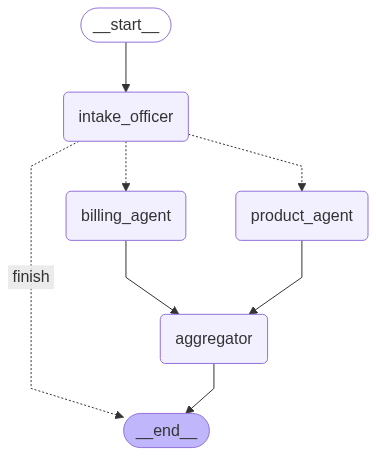

In [8]:
workflow = build_workflow()
display(Image(workflow.get_graph().draw_mermaid_png()))

In [12]:
# ──────────────── GRADIO UI ────────────────
def chat(user_message: str, history: list = None) -> tuple:
        # DEBUG: เพิ่ม log เพื่อดูว่า chat function ถูกเรียกกี่ครั้ง
    print(f"🔍 DEBUG: chat function called at {datetime.now().isoformat(timespec='milliseconds')}")
    print(f"🔍 DEBUG: user_message = '{user_message}'")
    
    if not user_message.strip():
        return history or [], "⚠️ กรุณากรอกข้อความ"
    history = history or []

    state = {
        "user_message": user_message,
        "chat_history": history,
        "assigned_agents": [],
        "agent_results": {},
        "final_response": "",
        "logs": []
    }
    
    print(f"🔍 DEBUG: About to invoke workflow with state keys: {list(state.keys())}")
    result = workflow.invoke(state)
    print(f"🔍 DEBUG: Workflow completed, result keys: {list(result.keys())}")
    
    if not user_message.strip():
        return history or [], "⚠️ กรุณากรอกข้อความ"
    # history = history or []

    # state = {
    #     "user_message": user_message,
    #     "chat_history": history,
    #     "assigned_agents": [],
    #     "agent_results": {},
    #     "final_response": "",
    #     "logs": []
    # }
    # result = workflow.invoke(state)
    # แสดงผลลัพธ์
    bot_reply = result.get("final_response", "ขออภัยค่ะ ไม่เข้าใจคำถาม กรุณาลองใหม่")
    logs = "\n".join(result.get("logs", []))
    history.append({"role": "user", "content": user_message})
    history.append({"role": "assistant", "content": bot_reply})
    return history, logs

def clear_chat():
    return [], ""

def create_demo():
    with gr.Blocks(title="LangGraph Map-Reduce Multi-Agent Demo") as demo:
        gr.Markdown(
            "# 🤖 LangGraph Map-Reduce Multi-Agent Demo\n" +
            "- พิมพ์ \"สินค้า บิล\" เพื่อให้ถามทั้ง 2 agent\n- พิมพ์ \"บิล\" หรือ \"สินค้า\" เพื่อให้ถาม agent เดียว"
        )
        with gr.Row():
            with gr.Column(scale=3):
                chatbot = gr.Chatbot(type='messages', label="💬 Chat History", height=300)
                msg = gr.Textbox(label="💭 พิมพ์ข้อความ", placeholder="สินค้า บิล", lines=2)
                with gr.Row():
                    send_btn = gr.Button("📤 Send", scale=2)
                    clear_btn = gr.Button("🗑️ Clear", scale=1)
            with gr.Column(scale=1):
                logbox = gr.Textbox(label="📋 System Logs", interactive=False, lines=20)
        send_btn.click(fn=chat, inputs=[msg, chatbot], outputs=[chatbot, logbox]).then(fn=lambda: "", outputs=[msg])
        clear_btn.click(fn=clear_chat, outputs=[chatbot, logbox])
        msg.submit(fn=chat, inputs=[msg, chatbot], outputs=[chatbot, logbox]).then(fn=lambda: "", outputs=[msg])
        gr.Examples(
            examples=["สินค้า", "บิล", "สินค้า บิล", "รายละเอียดสินค้า", "ข้อมูลบิล"],
            inputs=[msg],
            label="💡 ตัวอย่างคำถาม"
        )
    return demo

In [13]:
demo = create_demo()
demo.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


🔍 DEBUG: chat function called at 2025-07-08T10:58:19.964
🔍 DEBUG: user_message = 'สินค้า'
🔍 DEBUG: About to invoke workflow with state keys: ['user_message', 'chat_history', 'assigned_agents', 'agent_results', 'final_response', 'logs']
🔍 DEBUG: intake_router called at 2025-07-08T10:58:19.970
🔍 DEBUG: final_response = 
🔍 DEBUG: assigned_agents = ['product_agent']
🔍 DEBUG: router returning string 'product_agent'
🔍 DEBUG: Workflow completed, result keys: ['user_message', 'chat_history', 'assigned_agents', 'agent_results', 'final_response', 'logs']
Keyboard interruption in main thread... closing server.
